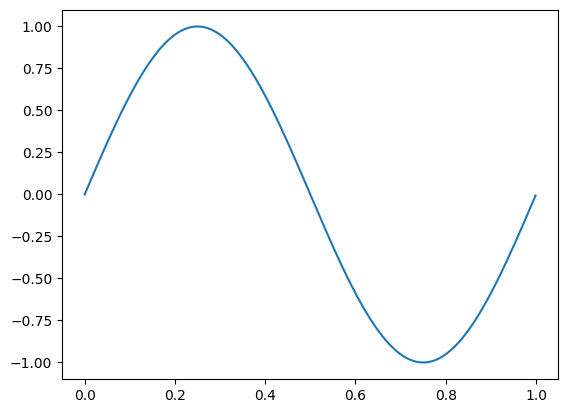

In [2]:
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import sine_data
import numpy as np

nnfs.init()

X, y = sine_data()

plt.plot(X, y)
plt.show()

In [3]:
# Linear Activation
class Activation_Linear:

    # Forward pass
    def forward(self, inputs): 
        self.inputs = inputs
        self.output = inputs

    # Backward pass
    def backward(self, dvalues):
        # Derivative is 1, 1*dvalues = dvalues - the chain rule
        self.dinputs = dvalues.copy()

### Common Loss class

In [4]:
class Loss:

    # Regularization loss calculation
    def regularization_loss(self, layer):
        
        regularization_loss = 0        
        
        # L1/L2 regularization (if factor greater than 0)
        
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
        
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
        
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
        
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)

        return regularization_loss
        
    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        return np.mean(sample_losses)

    def forward(self, y_pred, y_true):
        return []

### Mean Squared Error loss

In [6]:
class Loss_MeanSquaredError(Loss):   # L2 Loss
    
    # Forward pass
    def forward(self, y_pred, y_true): 
        # Calculate loss
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)
        return sample_losses
 
    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        outputs = len(dvalues[0])
        
        # Gradient on values
        self.dinputs = -2 * (y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples

### Mean Absolute Error Loss

In [ ]:
class Loss_MeanAbsoluteError(Loss):   # L1 loss

    # Forward pass
    def forward(self, y_pred, y_true):

        # Calculate loss
        sample_losses = np.mean(np.abs(y_true - y_pred), axis=-1)
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):

        samples = len(dvalues)
        outputs = len(dvalues[0])

        # Calculate gradient
        self.dinputs = np.sign(y_true - dvalues) / outputs

        # Normalize gradient
        self.dinputs = self.dinputs / samples
        